# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

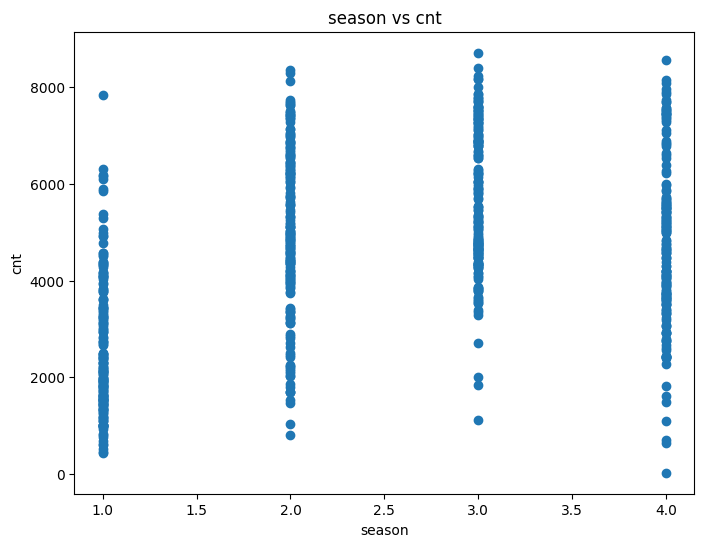

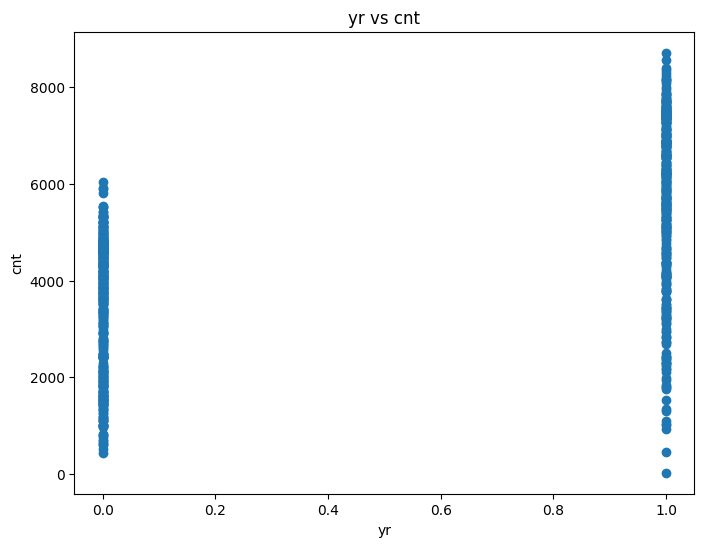

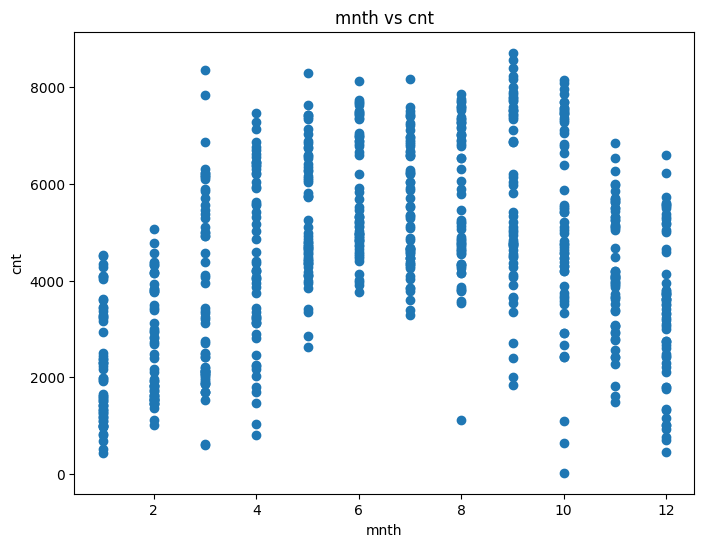

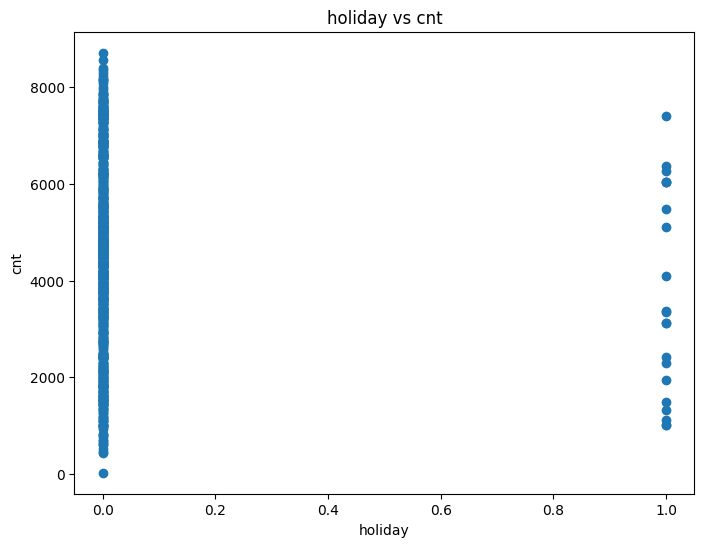

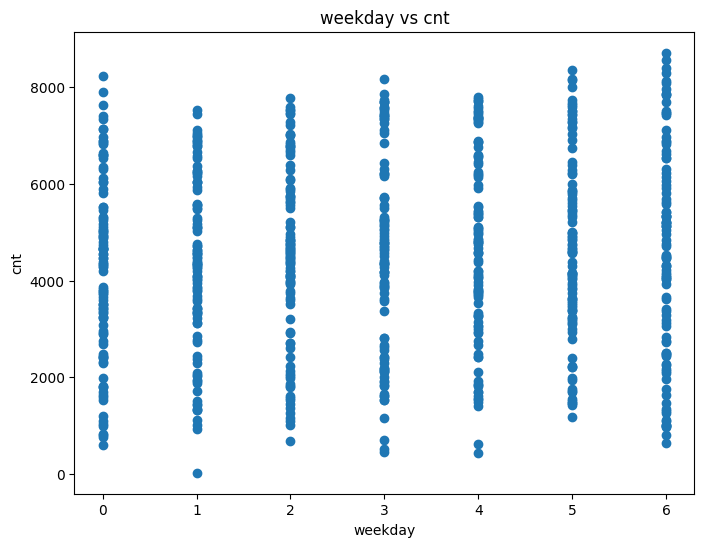

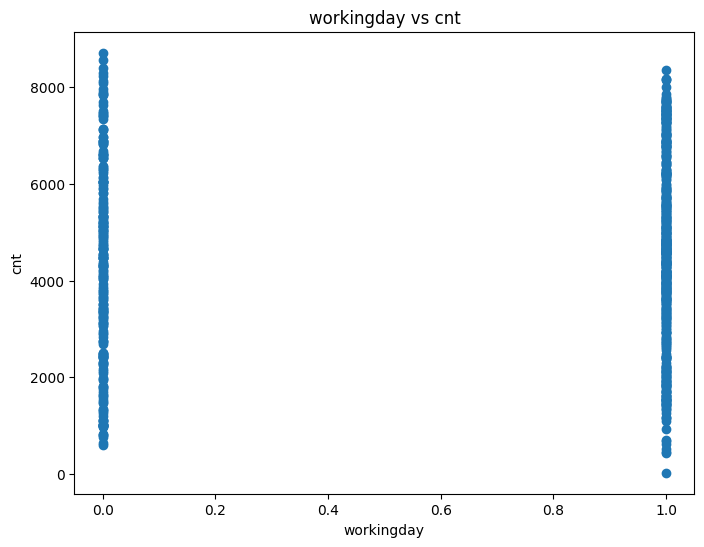

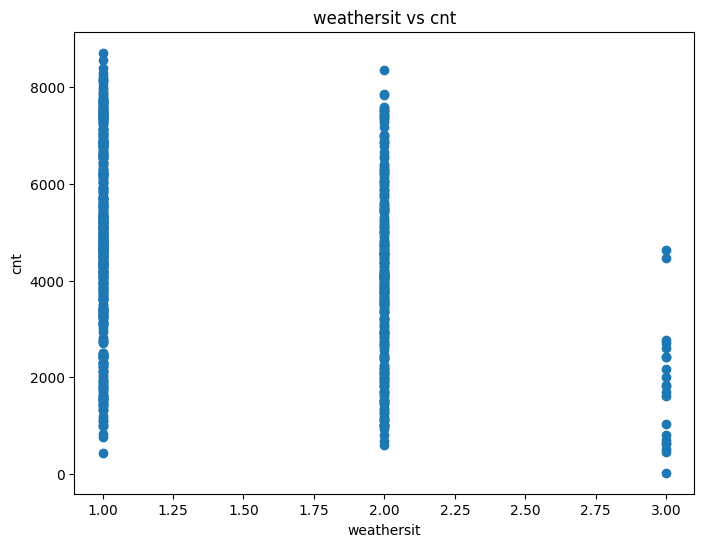

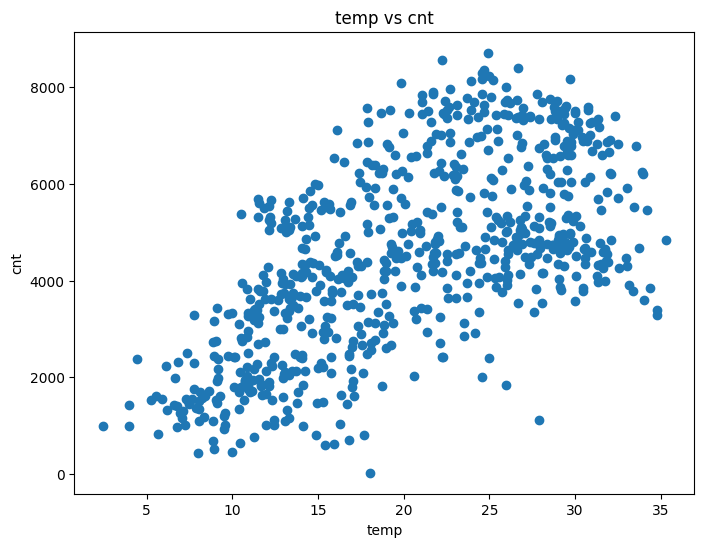

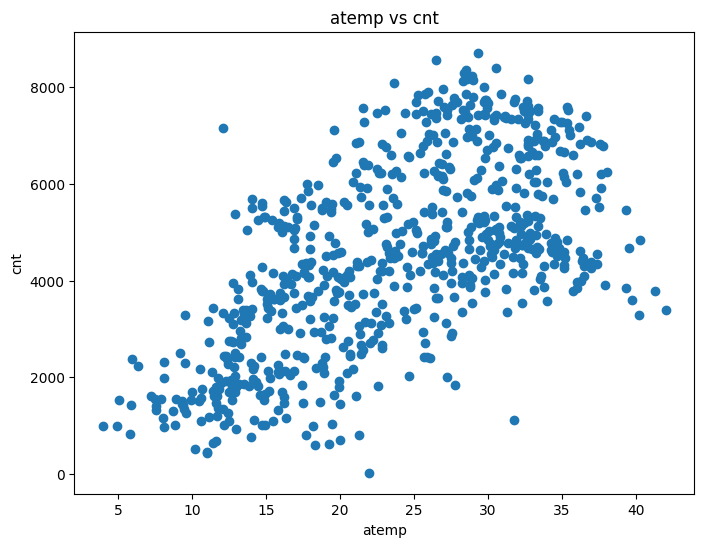

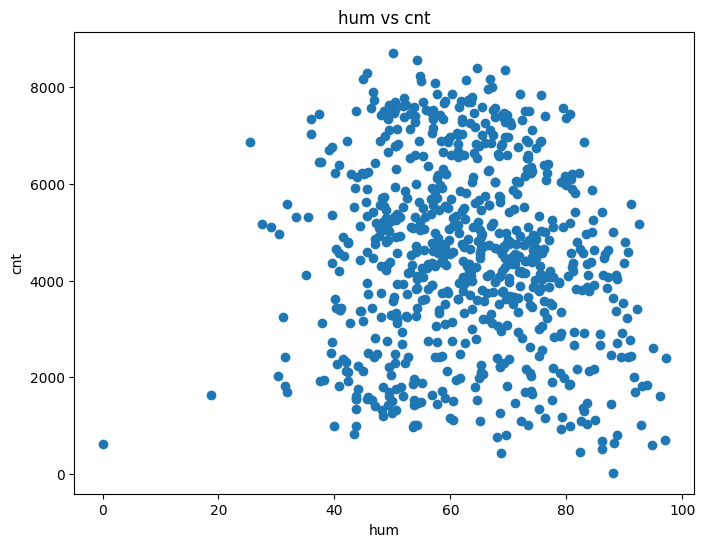

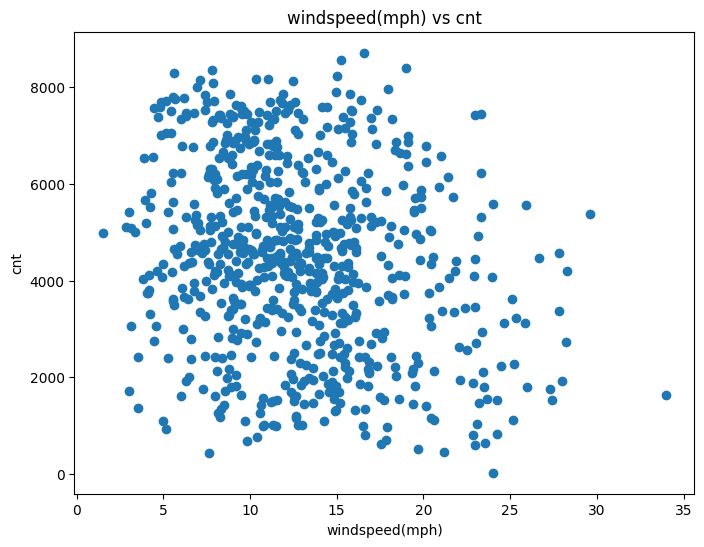

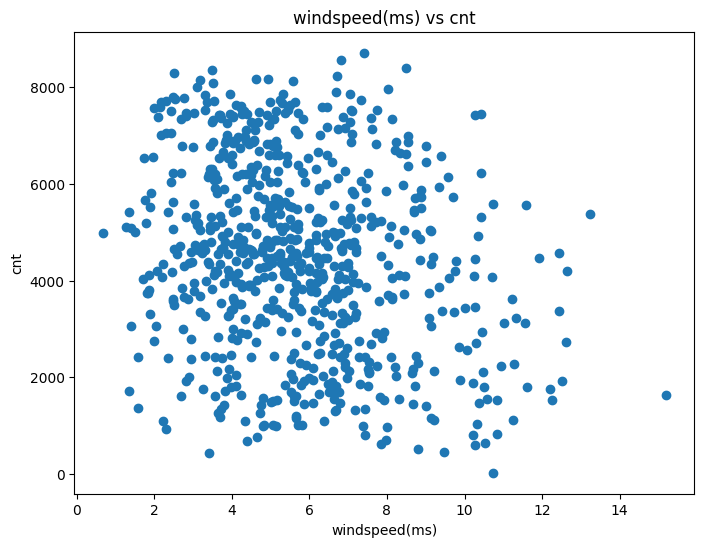

In [3]:
columns = df.columns

last_column = columns[-1]

for col in columns[:-1]:
    plt.figure(figsize=(8, 6))
    plt.scatter(df[col], df[last_column])
    plt.xlabel(col)
    plt.ylabel(last_column)
    plt.title(f'{col} vs {last_column}')
    plt.show()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
__Відповідь:__
1. Параболічний характер? спершу зростає, досягає максимуму влітку а далі спадає
2. Температура та температура за відчуттям

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [4]:
df_without_last = df[df.columns[:-1]]
correlation = df_without_last.corrwith(df[df.columns[-1]])
correlation


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [5]:

columns_ = columns[6:-1]

for col in columns_:
    correlation_ = df[col].corr(df[last_column])
    print(f"Correlation between '{col}' and '{last_column}': {correlation_}")

Correlation between 'weathersit' and 'cnt': -0.29739123883466345
Correlation between 'temp' and 'cnt': 0.6274940090334922
Correlation between 'atemp' and 'cnt': 0.6310656998491815
Correlation between 'hum' and 'cnt': -0.10065856213715522
Correlation between 'windspeed(mph)' and 'cnt': -0.2345449974216701
Correlation between 'windspeed(ms)' and 'cnt': -0.23454499742168927


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [6]:
mean_values = df[columns_].mean()

mean_values

weathersit         1.395349
temp              20.310776
atemp             23.717699
hum               62.789406
windspeed(mph)    12.762576
windspeed(ms)      5.705220
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [7]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [8]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [9]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [10]:
regressor = LinearRegression()
X = df[df.columns[:-1]]
y = df[df.columns[-1]]
regressor.fit(X, y)
weights = regressor.coef_
for feature_name, weight in zip(df.columns[:-1], weights):
    print(f"Feature: {feature_name}, Weight: {weight}")

Feature: season, Weight: 514.275498066804
Feature: yr, Weight: 2043.9366913387487
Feature: mnth, Weight: -40.962723778276086
Feature: holiday, Weight: -519.3859466510645
Feature: weekday, Weight: 68.49477858495129
Feature: workingday, Weight: 121.29258300429515
Feature: weathersit, Weight: -606.4550955832281
Feature: temp, Weight: 48.998354617581526
Feature: atemp, Weight: 71.91231638595741
Feature: hum, Weight: -10.230388721602594
Feature: windspeed(mph), Weight: 2400978672996.2417
Feature: windspeed(ms), Weight: -5370989291577.391


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [11]:

from sklearn.linear_model import Lasso

lasso_regressor = Lasso()
X = df[df.columns[:-1]]
y = df[df.columns[-1]]
lasso_regressor.fit(X, y)
lasso_weights = lasso_regressor.coef_
for feature_name, weight in zip(df.columns[:-1], lasso_weights):
    print(f"Feature: {feature_name}, Weight: {weight}")

Feature: season, Weight: 506.55127864980733
Feature: yr, Weight: 2036.231667697903
Feature: mnth, Weight: -38.07827028932158
Feature: holiday, Weight: -484.6519461865406
Feature: weekday, Weight: 68.93837479133964
Feature: workingday, Weight: 118.44759758668322
Feature: weathersit, Weight: -604.5667118927047
Feature: temp, Weight: 51.36326058561633
Feature: atemp, Weight: 69.91273749012194
Feature: hum, Weight: -10.352705204636587
Feature: windspeed(mph), Weight: -38.34106761310848
Feature: windspeed(ms), Weight: -0.0


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [12]:
from sklearn.linear_model import Ridge

ridge_regressor = Ridge()
X = df[df.columns[:-1]]
y = df[df.columns[-1]]
ridge_regressor.fit(X, y)
ridge_weights = ridge_regressor.coef_
for feature_name, weight in zip(df.columns[:-1], ridge_weights):
    print(f"Feature: {feature_name}, Weight: {weight}")

Feature: season, Weight: 507.80188185057483
Feature: yr, Weight: 2029.0890541970518
Feature: mnth, Weight: -38.47089727912446
Feature: holiday, Weight: -493.27801548381655
Feature: weekday, Weight: 69.11396965165993
Feature: workingday, Weight: 121.5244250292942
Feature: weathersit, Weight: -605.2055553731514
Feature: temp, Weight: 49.3167675959762
Feature: atemp, Weight: 71.78598727335604
Feature: hum, Weight: -10.383394500484673
Feature: windspeed(mph), Weight: -31.935501694592627
Feature: windspeed(ms), Weight: -14.276040263152836


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [13]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)
    
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)
coefs_lasso
coefs_ridge

array([[ 5.07801882e+02,  2.02908905e+03, -3.84708973e+01,
        -4.93278015e+02,  6.91139697e+01,  1.21524425e+02,
        -6.05205555e+02,  4.93167676e+01,  7.17859873e+01,
        -1.03833945e+01, -3.19355017e+01, -1.42760403e+01],
       [ 4.20961039e+02,  1.58131963e+03, -1.54666572e+01,
        -1.46436955e+02,  6.61233153e+01,  1.06998998e+02,
        -4.10178573e+02,  4.81667970e+01,  7.87848784e+01,
        -1.72880397e+01, -3.63843103e+01, -1.62647789e+01],
       [ 3.59764921e+02,  1.29619343e+03,  6.55388629e-01,
        -8.78675953e+01,  6.29289055e+01,  8.59931572e+01,
        -3.08794909e+02,  4.95374888e+01,  8.10569091e+01,
        -2.11171036e+01, -3.89562780e+01, -1.74145186e+01],
       [ 3.14968392e+02,  1.09838252e+03,  1.22882375e+01,
        -6.32736101e+01,  6.04583742e+01,  7.14707987e+01,
        -2.47032358e+02,  5.10818939e+01,  8.20094836e+01,
        -2.35447825e+01, -4.06259577e+01, -1.81609109e+01],
       [ 2.80752194e+02,  9.53038154e+02,  2.1037593

Проанализируйте динамику весов при увеличении параметра регуляризации:

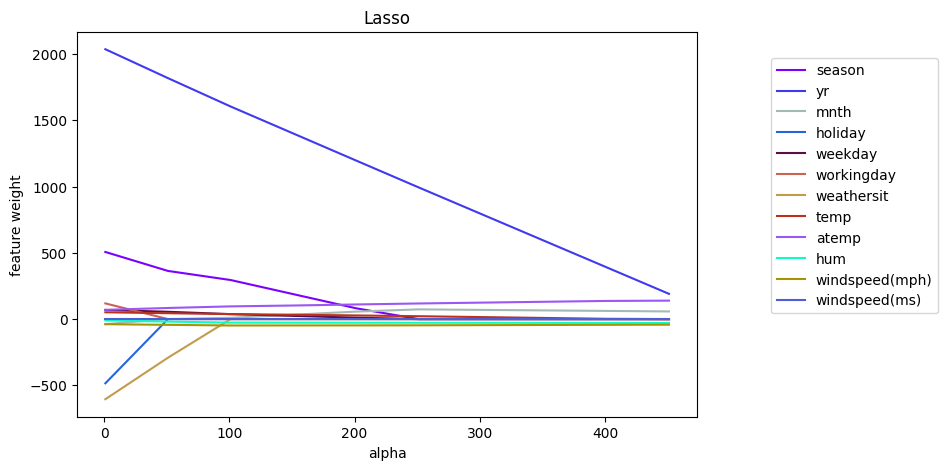

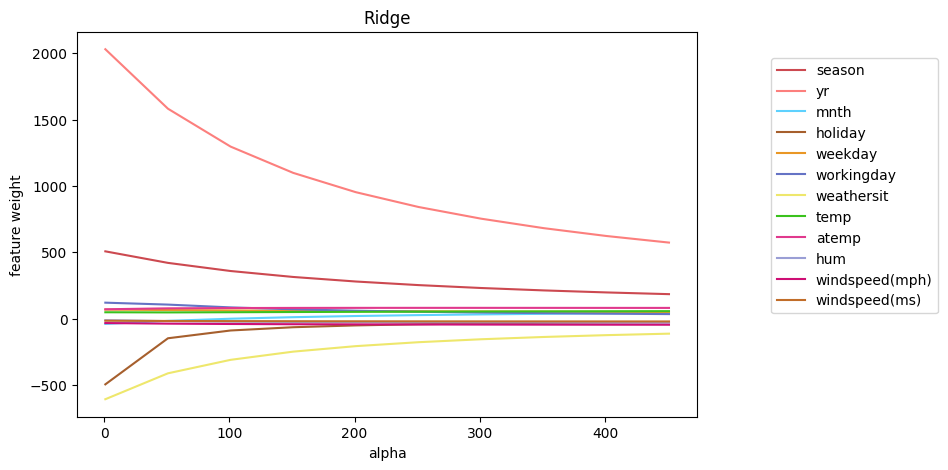

In [14]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

### Відповіді:
1. Судячи з графіків агресивніший Lasso
2. Знову ж таки, судячи з графіку ваги більшості ознак прямуватимуть до нуля. Чому - не підкажу((
3. Скоріше так, за графіком вони прямують до нуля, навіть при незначних значеннях alpha
4. Якщо порявняти два графіки то Lasso різко зменшує ваги наближаючи їх до нуля або робить їх рівними нулю, а Ridge зменшує , але не настільки. Тому, щоб відібрати неінформативні ознаки доцільніше використовувати Lasso

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [15]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

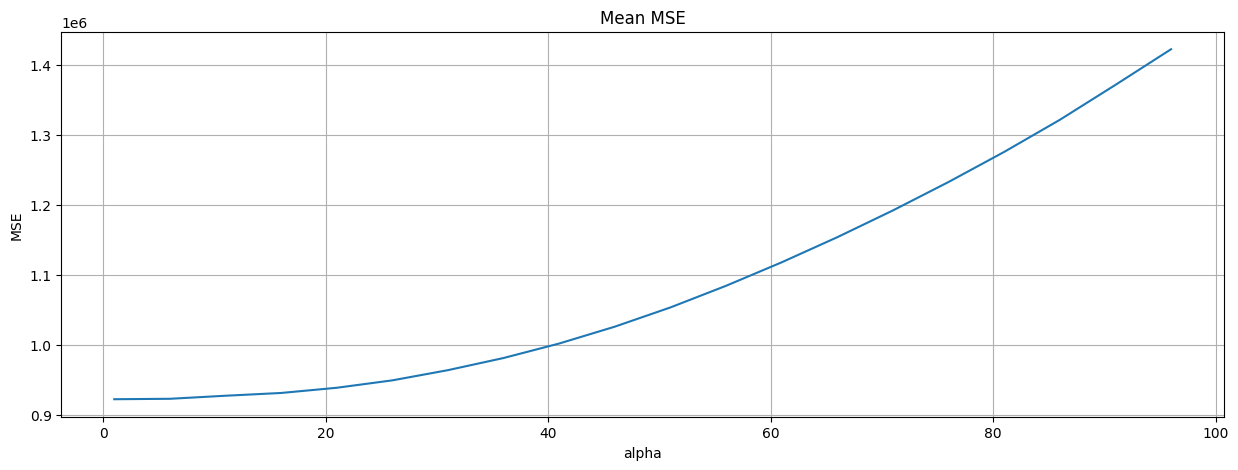

Selected alpha: 1
Feature: yr, Coefficient: 2036.231667697903
Feature: season, Coefficient: 506.55127864980733
Feature: workingday, Coefficient: 118.44759758668322
Feature: atemp, Coefficient: 69.91273749012194
Feature: weekday, Coefficient: 68.93837479133964
Feature: temp, Coefficient: 51.36326058561633
Feature: windspeed(ms), Coefficient: -0.0
Feature: hum, Coefficient: -10.352705204636587
Feature: mnth, Coefficient: -38.07827028932158
Feature: windspeed(mph), Coefficient: -38.34106761310848
Feature: holiday, Coefficient: -484.6519461865406
Feature: weathersit, Coefficient: -604.5667118927047


In [23]:
from sklearn.linear_model import LassoCV


alphas = np.arange(1, 100, 5)
lassoCV = LassoCV(alphas=alphas, cv=3)


lassoCV.fit(X, y)


mse_path = lassoCV.mse_path_
mean_mse = mse_path.mean(axis=1)


data_for_plot = list(zip(lassoCV.alphas_, mean_mse))


create_plot(data_for_plot, "Mean MSE", "alpha", "MSE")


feature_coef_pairs = list(zip(df.columns[:-1], lassoCV.coef_))


feature_coef_pairs.sort(key=lambda pair: pair[1], reverse=True)

print(f"Selected alpha: {lassoCV.alpha_}")
for pair in feature_coef_pairs:
    print(f"Feature: {pair[0]}, Coefficient: {pair[1]}")



Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


In [22]:

min_mse_alphas = lassoCV.alphas_[np.argmin(mse_path, axis=0)]
min_mse_values = np.min(mse_path, axis=0)


print("Alphas with minimum MSE:")
for i in range(len(min_mse_alphas)):
    print(f"Alpha = {min_mse_alphas[i]}, MSE = {min_mse_values[i]}")


Alphas with minimum MSE:
Alpha = 1, MSE = 783221.2007323423
Alpha = 51, MSE = 606705.6506735488
Alpha = 1, MSE = 1234577.1775608382


На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

__Ответ:__

In [18]:
Feature: yr, Coefficient: 2036.231667697903
Feature: season, Coefficient: 506.55127864980733
Feature: workingday, Coefficient: 118.44759758668322
Feature: atemp, Coefficient: 69.91273749012194
        
рік - так, логічно, коли прокат тільки відкрився - він був маловідомий, через рік розвинувся, тому кількість прокатів виросла
сезон - за умовою у нас найбільше значення відповідає зимі, коли число прокатів не може бути великим.
workingday - схоже або десь в мене помилки в коді, або цей прокат популярний серед кур''єрів чи інших людей , які використовують велосипуди для роботи
atemp - так, тут дивно лінійну залежність, тмоу твердження справджується

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [19]:
Feature: mnth, Coefficient: -38.07827028932158
Feature: windspeed(mph), Coefficient: -38.34106761310848
Feature: holiday, Coefficient: -484.6519461865406
Feature: weathersit, Coefficient: -604.5667118927047
        
mnth - залежність нелінійна, спершу зростає ,потім - спадає. Тому твердження тут справдиться, чи більше значення місяця - тим менше людей захочуть взяти велосипеди
windspeed - так, є спадаюча лінійна залежніть, логічно що при урагані, буде мало бажаючих покататися
holiday - - ось це дивно, оскільки на свята скоріше навпаки варто було б очікувати підвищеного попиту. Можливо справа у місцевих традиціях
weathersit - оцінка погоди, тут є спадаюча лінійна залежність, і це логічно, оскільки максимальне значення відповідає туману чи дощу

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [20]:
на жаль, подібних значень у мене немає, можливо десь помилка

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.